This public kernel is just intended to share my investigation on data exploratory. Since i have another private kernel to continue my work on tuning parameter and explorating more features, so this kernel is lack of visualizaton graph for now, i will try to add more explainations in upcoming commit......

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 300)
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
print('sklearn imported!')

import lightgbm as lgb
print('lightgbm imported!')

import warnings
warnings.filterwarnings('ignore')

sklearn imported!
lightgbm imported!


In [2]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

print(f'train set has {train_set.shape[0]} rows, and {train_set.shape[1]} features')
print(f'test set has {test_set.shape[0]} rows, and {test_set.shape[1]} features')

train set has 9557 rows, and 143 features
test set has 23856 rows, and 142 features


# Outlier

I had a look into train and test set, it turned out there is only one outlier value rez_esc in test set, and acorrding to the answer from competition host(https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403), we can safely change the value to 5

In [3]:
#outlier in test set which rez_esc is 99.0
test_set.loc[test_set['rez_esc'] == 99.0 , 'rez_esc'] = 5

# Missing Value

In [4]:
def missing_values(df):
    data_na = df.isnull().sum().values / df.shape[0] *100
    df_na = pd.DataFrame(data_na, index=df.columns, columns=['Count'])
    df_na = df_na.sort_values(by=['Count'], ascending=False)

    missing_value_count = df_na[df_na['Count']>0].shape[0]

    print(f'We got {missing_value_count} rows which have missing value in train set ')
    return df_na.head(6)

In [5]:
missing_values(train_set)

We got 5 rows which have missing value in train set 


,Count
rez_esc,82.954902
v18q1,76.823271
v2a1,71.779847
SQBmeaned,0.052318
meaneduc,0.052318
Id,0.000000


rez_esc represents "years behind in school", missing value could be filled as 0

meaneduc represents "average years of education for adults (18+)", missing value could be filled
as 0

v18q1 really depends on v18q

v2a1 depends on tipovivi3

We do not really need SQBxxxx features for polynomial in our case, and i will use fillna as 0 after at the last step of feature engineering

In [6]:
#Fill na
def repalce_v18q1(x):
    if x['v18q'] == 0:
        return x['v18q']
    else:
        return x['v18q1']

train_set['v18q1'] = train_set.apply(lambda x : repalce_v18q1(x),axis=1)
test_set['v18q1'] = test_set.apply(lambda x : repalce_v18q1(x),axis=1)

train_set['v2a1'] = train_set['v2a1'].fillna(value=train_set['tipovivi3'])
test_set['v2a1'] = test_set['v2a1'].fillna(value=test_set['tipovivi3'])

In [7]:
missing_values(train_set)

We got 3 rows which have missing value in train set 


,Count
rez_esc,82.954902
SQBmeaned,0.052318
meaneduc,0.052318
Id,0.000000
hogar_adul,0.000000
parentesco10,0.000000


# Feature Engineering
Replace object value, because some labels were generated whenever continuous variables have 1 or 0. The rule is to have being 1 yes=1 and no=0

In [8]:
cols = ['edjefe', 'edjefa']
train_set[cols] = train_set[cols].replace({'no': 0, 'yes':1}).astype(float)
test_set[cols] = test_set[cols].replace({'no': 0, 'yes':1}).astype(float)

It turns out orignial data lost one feature both for roof and electricity, so we manually add new feature

In [9]:
train_set['roof_waste_material'] = np.nan
test_set['roof_waste_material'] = np.nan
train_set['electricity_other'] = np.nan
test_set['electricity_other'] = np.nan

def fill_roof_exception(x):
    if (x['techozinc'] == 0) and (x['techoentrepiso'] == 0) and (x['techocane'] == 0) and (x['techootro'] == 0):
        return 1
    else:
        return 0
    
def fill_no_electricity(x):
    if (x['public'] == 0) and (x['planpri'] == 0) and (x['noelec'] == 0) and (x['coopele'] == 0):
        return 1
    else:
        return 0

train_set['roof_waste_material'] = train_set.apply(lambda x : fill_roof_exception(x),axis=1)
test_set['roof_waste_material'] = test_set.apply(lambda x : fill_roof_exception(x),axis=1)
train_set['electricity_other'] = train_set.apply(lambda x : fill_no_electricity(x),axis=1)
test_set['electricity_other'] = test_set.apply(lambda x : fill_no_electricity(x),axis=1)

More feature engineering

In [10]:
train_set['adult'] = train_set['hogar_adul'] - train_set['hogar_mayor']
train_set['dependency_count'] = train_set['hogar_nin'] + train_set['hogar_mayor']
train_set['dependency'] = train_set['dependency_count'] / train_set['adult']
train_set['child_percent'] = train_set['hogar_nin']/train_set['hogar_total']
train_set['elder_percent'] = train_set['hogar_mayor']/train_set['hogar_total']
train_set['adult_percent'] = train_set['hogar_adul']/train_set['hogar_total']
test_set['adult'] = test_set['hogar_adul'] - test_set['hogar_mayor']
test_set['dependency_count'] = test_set['hogar_nin'] + test_set['hogar_mayor']
test_set['dependency'] = test_set['dependency_count'] / test_set['adult']
test_set['child_percent'] = test_set['hogar_nin']/test_set['hogar_total']
test_set['elder_percent'] = test_set['hogar_mayor']/test_set['hogar_total']
test_set['adult_percent'] = test_set['hogar_adul']/test_set['hogar_total']

train_set['rent_per_adult'] = train_set['v2a1']/train_set['hogar_adul']
train_set['rent_per_person'] = train_set['v2a1']/train_set['hhsize']
test_set['rent_per_adult'] = test_set['v2a1']/test_set['hogar_adul']
test_set['rent_per_person'] = test_set['v2a1']/test_set['hhsize']

train_set['overcrowding_room_and_bedroom'] = (train_set['hacdor'] + train_set['hacapo'])/2
test_set['overcrowding_room_and_bedroom'] = (test_set['hacdor'] + test_set['hacapo'])/2

train_set['no_appliances'] = train_set['refrig'] + train_set['computer'] + train_set['television']
test_set['no_appliances'] = test_set['refrig'] + test_set['computer'] + test_set['television']

train_set['r4h1_percent_in_male'] = train_set['r4h1'] / train_set['r4h3']
train_set['r4m1_percent_in_female'] = train_set['r4m1'] / train_set['r4m3']
train_set['r4h1_percent_in_total'] = train_set['r4h1'] / train_set['hhsize']
train_set['r4m1_percent_in_total'] = train_set['r4m1'] / train_set['hhsize']
train_set['r4t1_percent_in_total'] = train_set['r4t1'] / train_set['hhsize']
test_set['r4h1_percent_in_male'] = test_set['r4h1'] / test_set['r4h3']
test_set['r4m1_percent_in_female'] = test_set['r4m1'] / test_set['r4m3']
test_set['r4h1_percent_in_total'] = test_set['r4h1'] / test_set['hhsize']
test_set['r4m1_percent_in_total'] = test_set['r4m1'] / test_set['hhsize']
test_set['r4t1_percent_in_total'] = test_set['r4t1'] / test_set['hhsize']

train_set['rent_per_room'] = train_set['v2a1']/train_set['rooms']
train_set['bedroom_per_room'] = train_set['bedrooms']/train_set['rooms']
train_set['elder_per_room'] = train_set['hogar_mayor']/train_set['rooms']
train_set['adults_per_room'] = train_set['adult']/train_set['rooms']
train_set['child_per_room'] = train_set['hogar_nin']/train_set['rooms']
train_set['male_per_room'] = train_set['r4h3']/train_set['rooms']
train_set['female_per_room'] = train_set['r4m3']/train_set['rooms']
train_set['room_per_person_household'] = train_set['hhsize']/train_set['rooms']

test_set['rent_per_room'] = test_set['v2a1']/test_set['rooms']
test_set['bedroom_per_room'] = test_set['bedrooms']/test_set['rooms']
test_set['elder_per_room'] = test_set['hogar_mayor']/test_set['rooms']
test_set['adults_per_room'] = test_set['adult']/test_set['rooms']
test_set['child_per_room'] = test_set['hogar_nin']/test_set['rooms']
test_set['male_per_room'] = test_set['r4h3']/test_set['rooms']
test_set['female_per_room'] = test_set['r4m3']/test_set['rooms']
test_set['room_per_person_household'] = test_set['hhsize']/test_set['rooms']

train_set['rent_per_bedroom'] = train_set['v2a1']/train_set['bedrooms']
train_set['edler_per_bedroom'] = train_set['hogar_mayor']/train_set['bedrooms']
train_set['adults_per_bedroom'] = train_set['adult']/train_set['bedrooms']
train_set['child_per_bedroom'] = train_set['hogar_nin']/train_set['bedrooms']
train_set['male_per_bedroom'] = train_set['r4h3']/train_set['bedrooms']
train_set['female_per_bedroom'] = train_set['r4m3']/train_set['bedrooms']
train_set['bedrooms_per_person_household'] = train_set['hhsize']/train_set['bedrooms']

test_set['rent_per_bedroom'] = test_set['v2a1']/test_set['bedrooms']
test_set['edler_per_bedroom'] = test_set['hogar_mayor']/test_set['bedrooms']
test_set['adults_per_bedroom'] = test_set['adult']/test_set['bedrooms']
test_set['child_per_bedroom'] = test_set['hogar_nin']/test_set['bedrooms']
test_set['male_per_bedroom'] = test_set['r4h3']/test_set['bedrooms']
test_set['female_per_bedroom'] = test_set['r4m3']/test_set['bedrooms']
test_set['bedrooms_per_person_household'] = test_set['hhsize']/test_set['bedrooms']

train_set['tablet_per_person_household'] = train_set['v18q1']/train_set['hhsize']
train_set['phone_per_person_household'] = train_set['qmobilephone']/train_set['hhsize']
test_set['tablet_per_person_household'] = test_set['v18q1']/test_set['hhsize']
test_set['phone_per_person_household'] = test_set['qmobilephone']/test_set['hhsize']

train_set['age_12_19'] = train_set['hogar_nin'] - train_set['r4t1']
test_set['age_12_19'] = test_set['hogar_nin'] - test_set['r4t1']    

train_set['escolari_age'] = train_set['escolari']/train_set['age']
test_set['escolari_age'] = test_set['escolari']/test_set['age']

train_set['rez_esc_escolari'] = train_set['rez_esc']/train_set['escolari']
train_set['rez_esc_r4t1'] = train_set['rez_esc']/train_set['r4t1']
train_set['rez_esc_r4t2'] = train_set['rez_esc']/train_set['r4t2']
train_set['rez_esc_r4t3'] = train_set['rez_esc']/train_set['r4t3']
train_set['rez_esc_age'] = train_set['rez_esc']/train_set['age']
test_set['rez_esc_escolari'] = test_set['rez_esc']/test_set['escolari']
test_set['rez_esc_r4t1'] = test_set['rez_esc']/test_set['r4t1']
test_set['rez_esc_r4t2'] = test_set['rez_esc']/test_set['r4t2']
test_set['rez_esc_r4t3'] = test_set['rez_esc']/test_set['r4t3']
test_set['rez_esc_age'] = test_set['rez_esc']/test_set['age']

In [11]:
train_set['dependency'] = train_set['dependency'].replace({np.inf: 0})
test_set['dependency'] = test_set['dependency'].replace({np.inf: 0})

print(f'train set has {train_set.shape[0]} rows, and {train_set.shape[1]} features')
print(f'test set has {test_set.shape[0]} rows, and {test_set.shape[1]} features')

train set has 9557 rows, and 183 features
test set has 23856 rows, and 182 features


In [12]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

aggr_mean_list = ['rez_esc', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 'parentesco2',
             'parentesco3', 'parentesco4', 'parentesco5', 'parentesco6', 'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11', 'parentesco12',
             'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9',]

other_list = ['escolari', 'age', 'escolari_age']

for item in aggr_mean_list:
    group_train_mean = train_set[item].groupby(train_set['idhogar']).mean()
    group_test_mean = test_set[item].groupby(test_set['idhogar']).mean()
    new_col = item + '_aggr_mean'
    df_train[new_col] = group_train_mean
    df_test[new_col] = group_test_mean

for item in other_list:
    for function in ['mean','std','min','max','sum']:
        group_train = train_set[item].groupby(train_set['idhogar']).agg(function)
        group_test = test_set[item].groupby(test_set['idhogar']).agg(function)
        new_col = item + '_' + function
        df_train[new_col] = group_train
        df_test[new_col] = group_test

print(f'new aggregate train set has {df_train.shape[0]} rows, and {df_train.shape[1]} features')
print(f'new aggregate test set has {df_test.shape[0]} rows, and {df_test.shape[1]} features')

new aggregate train set has 2988 rows, and 46 features
new aggregate test set has 7352 rows, and 46 features


In [13]:
df_test = df_test.reset_index()
df_train = df_train.reset_index()

train_agg = pd.merge(train_set, df_train, on='idhogar')
test = pd.merge(test_set, df_test, on='idhogar')

#fill all na as 0
train_agg.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)
print(f'new train set has {train_agg.shape[0]} rows, and {train_agg.shape[1]} features')
print(f'new test set has {test.shape[0]} rows, and {test.shape[1]} features')

new train set has 9557 rows, and 229 features
new test set has 23856 rows, and 228 features


In [14]:
#According to data descriptions,ONLY the heads of household are used in scoring. /
#All household members are included in test + the sample submission, but only heads of households are scored.
train = train_agg.query('parentesco1==1')

In [15]:
submission = test[['Id']]

#Remove useless feature to reduce dimension
train.drop(columns=['idhogar','Id', 'tamhog', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)
test.drop(columns=['idhogar','Id', 'tamhog', 'agesq', 'hogar_adul', 'SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned'], inplace=True)

correlation = train.corr()
correlation = correlation['Target'].sort_values(ascending=False)
print(f'The most 20 positive feature: \n{correlation.head(20)}')
print('*'*50)

print(f'The most 20 negative feature: \n{correlation.tail(20)}')

The most 20 positive feature: 
Target                  1.000000
escolari_mean           0.423626
escolari_max            0.373091
escolari                0.333791
meaneduc                0.331489
escolari_min            0.306693
cielorazo               0.295249
eviv3                   0.293540
instlevel8_aggr_mean    0.293307
epared3                 0.280947
escolari_age_min        0.276896
pisomoscer              0.275452
adult_percent           0.263882
etecho3                 0.261142
escolari_age_mean       0.258934
escolari_sum            0.256726
paredblolad             0.254469
edjefe                  0.235687
instlevel8              0.235102
escolari_age            0.232205
Name: Target, dtype: float64
**************************************************
The most 20 negative feature: 
child_percent       -0.263882
hogar_nin           -0.266309
dependency_count    -0.283908
dependency          -0.304563
child_per_room      -0.305541
child_per_bedroom   -0.308308
elimbasu5         

# Model - LightGBM
Parameter values are just copied from Misha Lisovyi for now

In [32]:
def plot_feature_importances(df, n = 15):
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.figure(figsize=(10,5))
    # Bar plot of n most important features
    sns.barplot(y = 'feature', 
                            x = 'importance_normalized',data = df.loc[:n, :],orient='h')

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size = 18)

In [17]:
y = train['Target']

train.drop(columns=['Target'], inplace=True)

#parameter value is copied from 
clf = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.1, objective='multiclass',
                             random_state=None, silent=True, metric='None', 
                             n_jobs=4, n_estimators=5000, class_weight='balanced',
                             colsample_bytree =  0.89, min_child_samples = 90, num_leaves = 14, subsample = 0.96)

In [18]:
kfold = 5
kf = StratifiedKFold(n_splits=kfold, shuffle=True)

predicts_result = []
feature_names = list(train.columns)
importances = np.zeros(len(feature_names))

for train_index, test_index in kf.split(train, y):
    print("###")
    X_train, X_val = train.iloc[train_index], train.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_val,y_val)], 
            eval_names = ['train', 'valid'],early_stopping_rounds=400,verbose=200)
    importances += clf.feature_importances_ / kf.n_splits
    predicts_result.append(clf.predict(test))
feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})

###
Training until validation scores don't improve for 400 rounds.
[200]	train's multi_logloss: 0.26489	valid's multi_logloss: 0.991354
[400]	train's multi_logloss: 0.0892736	valid's multi_logloss: 1.08609
Early stopping, best iteration is:
[180]	train's multi_logloss: 0.29777	valid's multi_logloss: 0.988047
###
Training until validation scores don't improve for 400 rounds.
[200]	train's multi_logloss: 0.254014	valid's multi_logloss: 0.991581
[400]	train's multi_logloss: 0.0829796	valid's multi_logloss: 1.12082
Early stopping, best iteration is:
[102]	train's multi_logloss: 0.477825	valid's multi_logloss: 0.964282
###
Training until validation scores don't improve for 400 rounds.
[200]	train's multi_logloss: 0.263425	valid's multi_logloss: 1.01236
[400]	train's multi_logloss: 0.0883953	valid's multi_logloss: 1.12327
Early stopping, best iteration is:
[111]	train's multi_logloss: 0.462055	valid's multi_logloss: 0.990199
###
Training until validation scores don't improve for 400 rounds.


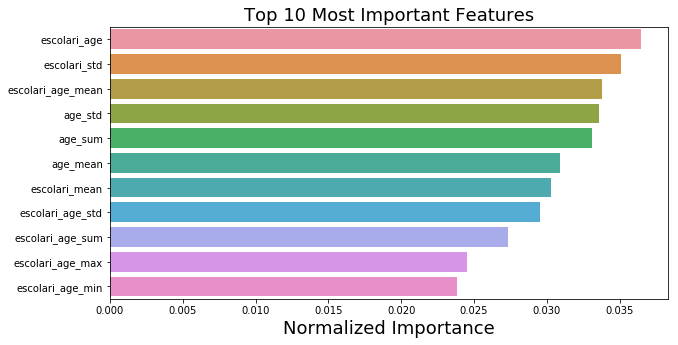

In [34]:
plot_feature_importances(feature_importances,10)

In [35]:
submission['Target'] = np.array(predicts_result).mean(axis=0).round().astype(int)
submission.to_csv('submission.csv', index = False)